# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

print(tf.__version__)
if tf.__version__ < '1.4.0':
     
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

import os
import time


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# 定义TensorFlow配置
config = tf.ConfigProto(allow_soft_placement=True)
# 配置GPU内存分配方式，按需增长，很关键
config.gpu_options.allow_growth = True
# 配置可使用的显存比例
config.gpu_options.per_process_gpu_memory_fraction = 0.5


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/mnt/lost+found/data/gen/jinju.classic/data/faster_rcnn_resnet101/80k.fixed.size.resizer/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/zlong/data/gen/jinju.classic/mscoco_label_map.pbtxt'

NUM_CLASSES = 9

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
layers = [op.name for op in detection_graph.get_operations() if op.type=='Conv2D' ]
feature_nums = [int(detection_graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 107
Total number of feature channels: 53256


In [8]:
for op in layers:
    print(op)

FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/conv1/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_1/bottleneck_v1/conv1/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_1/bottleneck_v1/conv2/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_1/bottleneck_v1/conv3/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_1/bottleneck_v1/shortcut/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_2/bottleneck_v1/conv1/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_2/bottleneck_v1/conv2/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_2/bottleneck_v1/conv3/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_3/bottleneck_v1/conv1/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/unit_3/bottleneck_v1/conv2/Conv2D
FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/block1/uni

In [11]:
import random
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'jyz_test'
PATH_TO_TEST_IMAGES_DIR = '/mnt/lost+found/data/gen/image.scale.fix.736.491/images'
TEST_IMAGE_PATHS = [  ]
for file_name in os.listdir(PATH_TO_TEST_IMAGES_DIR):
    TEST_IMAGE_PATHS.append( os.path.join(PATH_TO_TEST_IMAGES_DIR, file_name))
    if file_name.lower().endswith("jpg"):
        if random.random() < 1e-4:
            TEST_IMAGE_PATHS.append( os.path.join(PATH_TO_TEST_IMAGES_DIR, file_name))
    
    if len(TEST_IMAGE_PATHS) >= 1:
        break
    
TEST_IMAGE_PATHS.sort()
# for p in TEST_IMAGE_PATHS:
#     print(p)

# Size, in inches, of the output images.
IMAGE_SIZE = (18, 12)
GPU_NUM = 2

print(TEST_IMAGE_PATHS)

# TEST_IMAGE_PATHS = ['bug/220kv音朱二线055号左相地线未使用铝包带-p2260747.jpg']

['/mnt/lost+found/data/gen/image.scale.fix.736.491/images/18062818590.jpg']


/mnt/lost+found/data/gen/image.scale.fix.736.491/images/18062818590.jpg
===Read Spend: %.3f sec 0.024141550064086914
===Detection Spend: %.3f sec 1.507303237915039
4.0 : 0.99979955
4.0 : 0.9995499
3.0 : 0.99937063


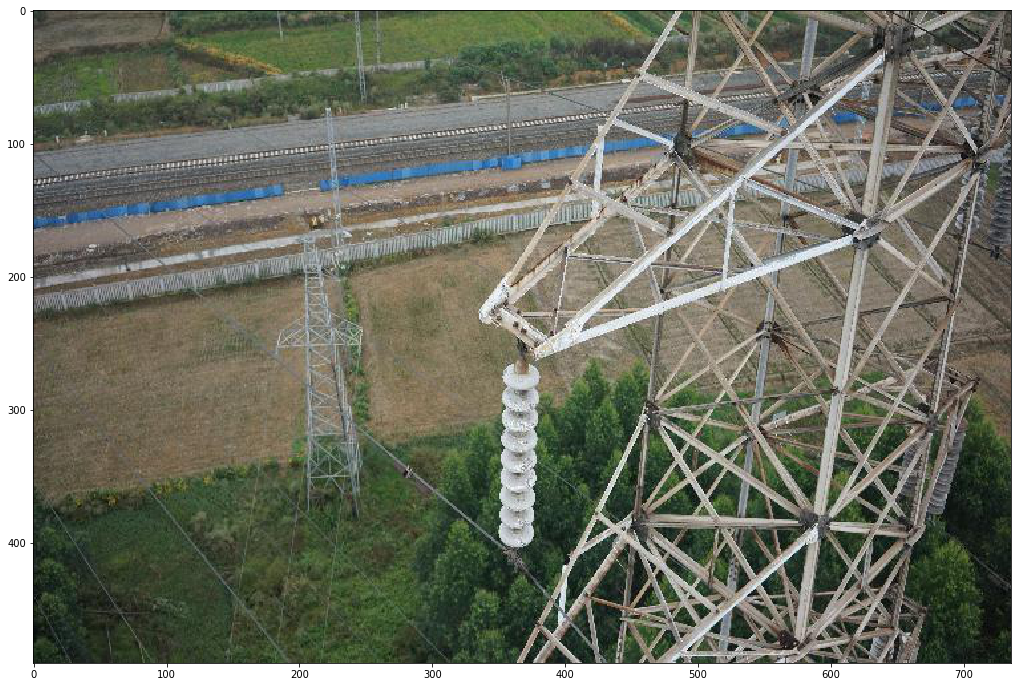

In [21]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph, config=config) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        i = 0
        for image_path in TEST_IMAGE_PATHS:
            print(image_path)

            start_time = time.time()

            image = mpimg.imread(image_path)

            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image, axis=0)
            print('===Read Spend: %.3f sec', time.time() - start_time)
            start_time = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            print('===Detection Spend: %.3f sec', time.time() - start_time)
            start_time = time.time()
            i = i + 1

            for score in scores[0]:
                if score > 0.5 : print(classes[0][scores[0].tolist().index(score)], ':', score)
                    
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image)

### 展示层之后的结果

In [22]:
def show_layer(layer_name,sess,image_np_expanded):
    tensor = detection_graph.get_tensor_by_name(layer_name)
    (tensor_value,) = sess.run([tensor,],feed_dict={image_tensor: image_np_expanded})
    print(tensor_value.shape)
    tensor_transpose = sess.run(tf.transpose(tensor_value, [3, 0, 1, 2]))
    fig5, ax5 = plt.subplots(nrows=1, ncols=4, figsize=(32, 32))
    for i in range(4):
        ax5[i].imshow(tensor_transpose[i][0])
    plt.title('layer_name '+str(tensor_value.shape))
    plt.show()
    

(1, 246, 368, 64)


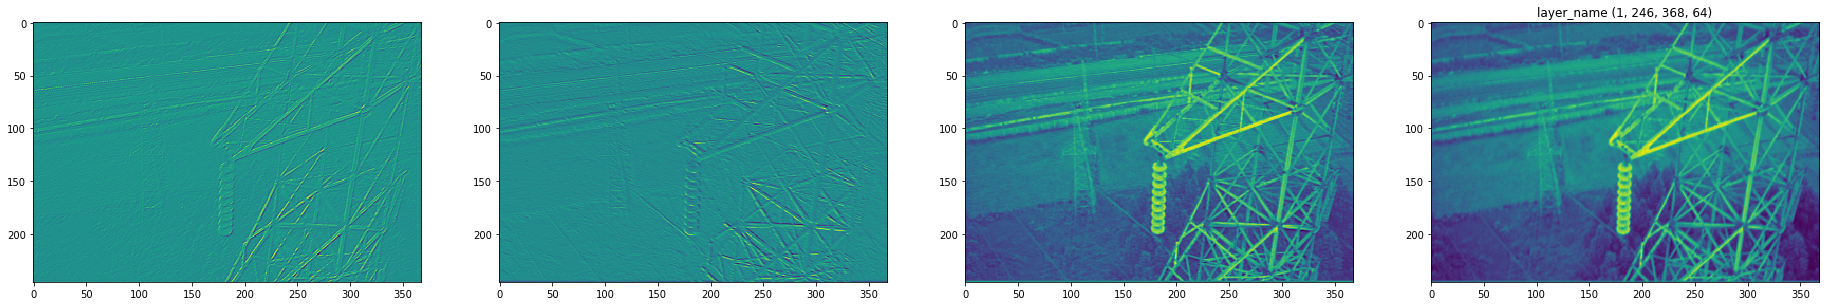

(1, 123, 184, 64)


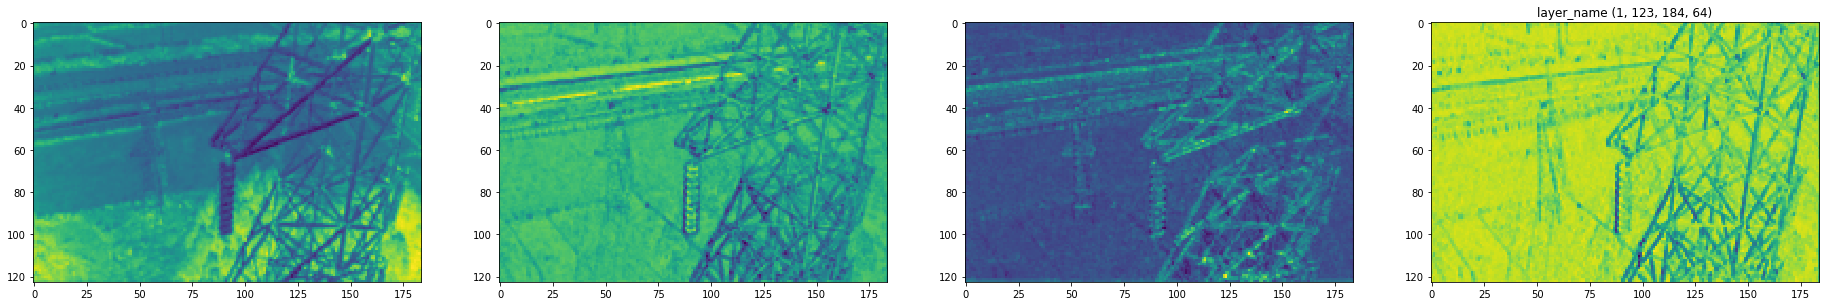

In [23]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph, config=config) as sess:
        # Definite input and output Tensors for detection_graph
        image_path = TEST_IMAGE_PATHS[0]

        image = mpimg.imread(image_path)

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)

        for op_name in layers[:2]:
            layer_name = op_name + ':0'
            show_layer(layer_name,sess,image_np_expanded)

### CNNVis

In [30]:
sess = tf.Session(graph=detection_graph, config=config)

In [34]:

from tf_cnnvis import *

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

layers = ['FirstStageFeatureExtractor/resnet_v1_101/resnet_v1_101/conv1/Conv2D']


image_path = TEST_IMAGE_PATHS[0]
image = mpimg.imread(image_path)
image_np_expanded = np.expand_dims(image, axis=0)




In [38]:

is_success = deepdream_visualization(sess_graph_path = detection_graph, value_feed_dict = {image_tensor: image_np_expanded}, 
                                     layer=layers[0], classes = [1, 2, 3, 4, 5,6,7,8,9],
                                     path_logdir=os.path.join("Log","Inception5"), 
                                     path_outdir=os.path.join("Output","Inception5"))

ValueError: Please input a frozen graph (no variables). Or pass in the session object.

In [35]:

with sess.as_default():
    is_success = activation_visualization(sess_graph_path = None, value_feed_dict={image_tensor: image_np_expanded}, 
                                          layers=layers, path_logdir=os.path.join("Log","AlexNet"), 
                                          path_outdir=os.path.join("Output","AlexNet"))
            

ValueError: No variables to save

In [36]:
with sess.as_default():
    is_success = deconv_visualization(sess_graph_path = None, value_feed_dict={image_tensor: image_np_expanded}, 
                                          layers=layers, path_logdir=os.path.join("Log","AlexNet"), 
                                          path_outdir=os.path.join("Output","AlexNet"))

ValueError: No variables to save

In [ ]:
sess.close()